In [1]:
from modules.srs import DefaultCollections
from modules.srs.scheduler import V1

user_collection = DefaultCollections.get("GuitarStandard")
user_collection.set_active_track('String 2')

In [2]:
scheduler = V1

reviewing_queue = scheduler.generate_reviewing_queue(user_collection)
reviewing_queue

[OrderedReviewItem(
 	item=B₃,
 	due_date=2023-02-20 19:18:09.174678+00:00
 ),
 OrderedReviewItem(
 	item=C₄,
 	due_date=2023-02-20 19:18:15.037133+00:00
 ),
 OrderedReviewItem(
 	item=C₄♯,
 	due_date=2023-02-20 19:18:11.355797+00:00
 )]

# Application Server - Game Logic

Management of which notes the user should play, at any given time.

# Spaced Repetition Crash Course

The basis of the game logic seeks to utilize psychology to maximize learning potential

## Spacing Effect
- Psychological phenomenon first studied in 1885, later studies have replicated it
- Conclusion: things (notes, concepts, ideas, memories, etc) reviewed in increasingly increasing intervals tend to be remembered more
- Reviewing a thing after 1 day, then 2 days, then 4 days tends to encode the thing in memory better long-term than reviewing a topic every day.

## Forgetting Curve
- The rate of forgetting of a particular memory
- Found along similar research in the spacing effect (almost a natural conclusion of it)
- Generally follows an exponential decay function, where the probability of remembering falls off exponentially as time goes on

<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/4/42/Forgetting_curve_decline.svg" height="300px"/>
</div>

## Combining the two - A spaced repetition system (SRS)
- These two ideas can be combined to form a system of learning that seeks to maximize recall while minimizing work required to maintain said recall
- If user has periodic "review" sessions, where they review items that are due, this can be the start of an SRS system
- Determining when items are due are based on the findings of the spacing effect and forgetting curve, scheduling items to be due in exponentially increasing intervals (with some exceptions)

<div align="center">
    <img src="https://149664534.v2.pressablecdn.com/wp-content/uploads/2022/01/learning-v1-updated.png"/>
</div>

# Basic Interval Progression: A Perfect Learner

When a user gets things correct, they see the same note less and less often.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from copy import deepcopy


intervals = []
x = list(range(9))

In [4]:
test_item = deepcopy(
    user_collection.get_active_track().review_items[0]
)

def perfect_learner(reps):
    return 0

for i in range(9):
    interval = (
        scheduler._calculate_interval(test_item)
        / datetime.timedelta(hours=1)
    )
    intervals.append(interval)
    scheduler.review(test_item, perfect_learner(i), 0)

Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item graduated
Item is reviewing
SM-2 quality of 5
Updating ease factor
Item is reviewing
SM-2 quality of 5
Updating ease factor
Item is reviewing
SM-2 quality of 5
Updating ease factor


In [5]:
sns_df = pd.DataFrame.from_records([x, intervals]).T
sns_df.columns = ['repetitions', 'interval (hours)']

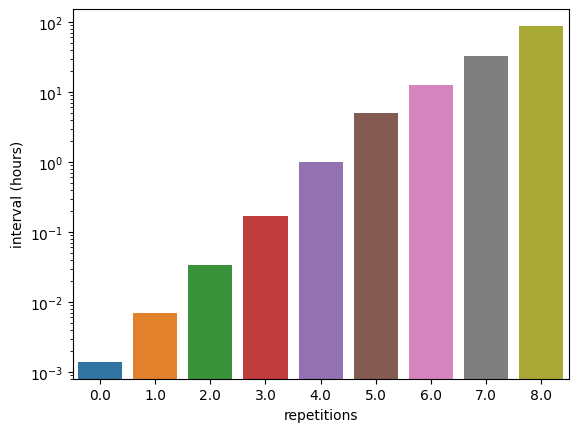

In [6]:
perfect_bar = sns.barplot(data=sns_df,
                        x='repetitions',
                        y='interval (hours)')
_ = perfect_bar.set(yscale='log')

In [7]:
intervals # in hours

[0.001388888888888889,
 0.006944444444444444,
 0.03333333333333333,
 0.16666666666666666,
 1.0,
 5.0,
 12.5,
 32.5,
 87.75]

# State Machine

![FSM](./fsm.svg)

In [42]:
import random
from modules.srs import ReviewState

test_item = deepcopy(user_collection.get_active_track().review_items[0])
test_item

n_reps = 37
intervals = []
states = []
x = list(range(n_reps))

In [9]:
def learner_that_forgets(reps):
    if reps == 30:
        return 1 # autofail for rep 30
    
    # learner that tends to learn over time
    # (choosing 1/incorrect with less reps)    
    return random.choices(
        [0, 1], 
        weights=[reps, max(20 - reps, 0)]
    )[0]

In [43]:
for i in range(n_reps):
    interval = scheduler._calculate_interval(test_item) / datetime.timedelta(hours=1)
    intervals.append(interval)
    states.append(test_item.state)
    scheduler.review(test_item, learner_that_forgets(i), 0)

sns_df = pd.DataFrame.from_records([x, intervals, states]).T
sns_df.columns = ['repetitions', 'interval (hours)', 'state']

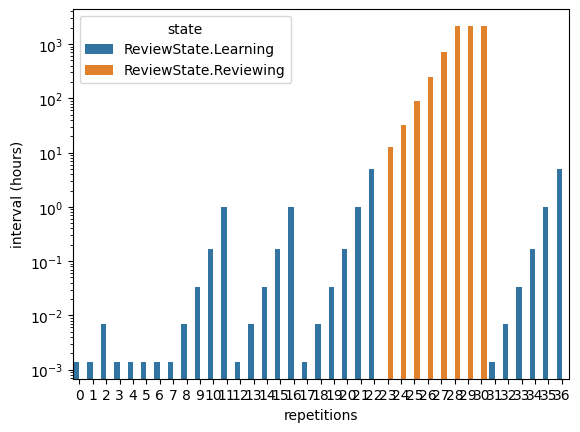

In [11]:
bar = sns.barplot(
    data=sns_df,
    x='repetitions', y='interval (hours)',
    hue='state'
)
_ = bar.set(yscale='log')

# Ease factor

How the algorithm estimates item difficulty, and scales interval changes appropriately.

In [40]:
import random
from copy import deepcopy
from modules.srs import ReviewState
import datetime
import pandas as pd
import seaborn as sns

test_item = deepcopy(user_collection.get_active_track().review_items[0])
test_item

n_reps = 70
intervals = []
states = []
x = list(range(n_reps))

In [39]:
# Answer incorrectly every 9 repetitions
def learner_that_forgets_periodically(reps):
    return int(reps % 9 == 0)

In [41]:
for i in range(n_reps):
    interval = (
        scheduler._calculate_interval(test_item)
        / datetime.timedelta(hours=1)
    )
    intervals.append(interval)
    states.append(test_item.state)
    scheduler.review(test_item, learner_that_forgets_periodically(1 + i), 0)

sns_df = pd.DataFrame.from_records([x, intervals, states]).T
sns_df.columns = ['repetitions', 'interval (hours)', 'state']

Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item graduated
Item is reviewing
SM-2 quality of 5
Updating ease factor
Item is reviewing
SM-2 quality of 5
Updating ease factor
Item is reviewing
SM-2 quality of 2.0
SM-2 q < 3, resetting learning step
Updating ease factor
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item moved to next learning step
Item is learning
Item was correct
Item graduated
Item is reviewing
SM-2 

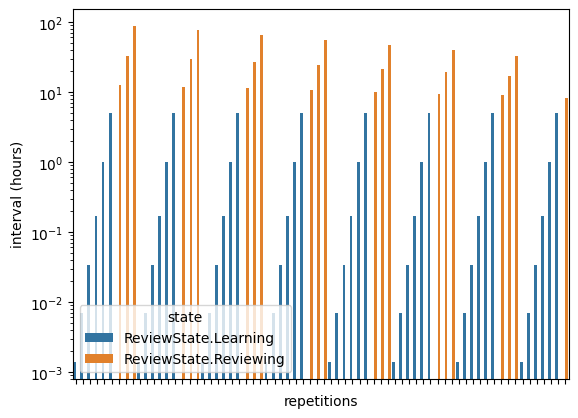

In [42]:
bar = sns.barplot(
    data=sns_df,
    x='repetitions', y='interval (hours)',
    hue='state'
)
_ = bar.set(yscale='log', xticklabels=[])
sns.move_legend(bar, "lower left")

# Application Server + Simulated DSP Demo

In [ ]:
import datetime
import heapq


while len(reviewing_queue) > 0:
    print(reviewing_queue)
    now = datetime.datetime.now(datetime.timezone.utc)
    # TODO: Time zone should match system time zone, conversion needed here
    tomorrow = datetime.datetime(
        year=now.year, month=now.month, day=now.day, tzinfo=datetime.timezone.utc
    ) + datetime.timedelta(days=1)

    next_item = heapq.heappop(reviewing_queue)
    
    note_distance: int
    while True:
        try:
            print("Enter note distance: ")
            note_distance = int(input())
            break
        except ValueError:
            continue

    scheduler.review(next_item.item, note_distance, 0)
    
    due_date = scheduler.get_due_date(user_collection, next_item.item)
    if due_date < tomorrow:
        next_item.due_date = due_date
        heapq.heappush(reviewing_queue, next_item)

'D₄'